In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections, functools, operator

sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

# Catch Joe

The problem is to properly classify Joe from the list of users' sessions. 


# Read dataset

In [3]:
data = pd.read_json("dataset.json")
data.head()

browser          os locale  user_id gender             location  \
0  Firefox      Ubuntu  ru_RU      105      m          USA/Chicago   
1  Firefox   Windows 8  pl-PL       11      m          USA/Chicago   
2   Chrome      Ubuntu  zh-CN       17      m  Singapore/Singapore   
3   Chrome  Windows 10  pt-BR      134      f     Australia/Sydney   
4  Firefox  Windows 10  en-SG       92      f          USA/Chicago   

                                               sites      time       date  
0  [{'site': 'mail.google.com', 'length': 50}, {'...  09:03:00 2017-01-08  
1  [{'site': 'meduza.org', 'length': 40}, {'site'...  13:57:00 2016-10-05  
2  [{'site': 'facebook.net', 'length': 74}, {'sit...  02:06:00 2017-03-28  
3  [{'site': 'verisign.com', 'length': 111}, {'si...  21:49:00 2017-06-25  
4  [{'site': 'live.com', 'length': 79}, {'site': ...  00:05:00 2016-02-10

# Joe dataset

In [4]:
joe_data = data[data["user_id"] == 0]
joe_data.head()

browser          os locale  user_id gender        location  \
77   Firefox  Windows 10  ru_RU        0      m    France/Paris   
198   Chrome  Windows 10  ru_RU        0      m     USA/Chicago   
200  Firefox  Windows 10  ru_RU        0      m  Canada/Toronto   
354  Firefox  Windows 10  ru_RU        0      m     USA/Chicago   
710  Firefox      Ubuntu  ru_RU        0      m    France/Paris   

                                                 sites      time       date  
77   [{'site': 'mail.google.com', 'length': 86}, {'...  10:13:00 2016-04-30  
198  [{'site': 'youtube.com', 'length': 71}, {'site...  18:26:00 2016-11-22  
200  [{'site': 'mail.google.com', 'length': 140}, {...  16:57:00 2017-08-05  
354  [{'site': 'mail.google.com', 'length': 207}, {...  03:42:00 2017-02-19  
710  [{'site': 'vk.com', 'length': 56}, {'site': 's...  19:15:00 2016-04-08

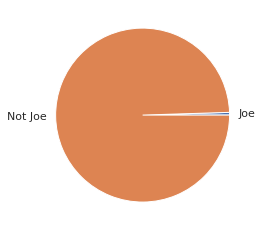

In [5]:
jl = joe_data.size
dl = data.size
dis = {'Who' : ["Joe", "Not Joe"], 'Number': [jl, (dl - jl)]}
dis = pd.DataFrame(dis)
ax = plt.pie(data=dis, x='Number', labels='Who')
plt.show()

As we can see there is a huge disproportion between the number of Joes and Not Joes. 

# Exploratory Analysis

# How many unique users do we have?

In [6]:
data['user_id'].nunique()

200

In [7]:
data['user_id'].value_counts()

105    400
103    400
144    400
153    400
66     400
      ... 
58     400
166    400
20     400
142    400
55     400
Name: user_id, Length: 200, dtype: int64

We have 200 unique users each having 400 entries in a dataset.

# Gender

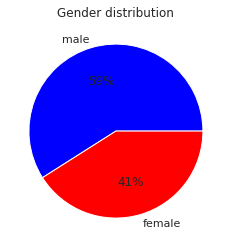

In [8]:
g = data['gender'].value_counts()
g = g.divide(400, level='int')
colors = ['blue', 'red']
labels = ['male', 'female']
plt.pie(g, colors = colors, labels=labels, autopct='%.0f%%')
plt.title('Gender distribution')
plt.show()

We have 118 males and 82 females.

In [9]:
joe_data['gender'].value_counts().divide(400)

m    1.0
Name: gender, dtype: float64

Joe is always a male.

# Location

In [10]:
data['location'].nunique()

21

There are 21 unique locations.

In [11]:
data['location'].value_counts()

New Zealand/Auckland     6063
France/Paris             5912
Germany/Berlin           5033
Singapore/Singapore      5004
Australia/Sydney         4277
Japan/Tokyo              4198
Canada/Vancouver         4196
Canada/Toronto           4103
USA/Chicago              3966
UK/London                3875
USA/San Francisco        3598
Malaysia/Kuala Lumpur    3441
Spain/Madrid             3358
Italy/Rome               3348
Russia/Moscow            3264
USA/Miami                3181
India/Delhi              3064
China/Shanghai           2758
Netherlands/Amsterdam    2701
USA/New York             2385
Brazil/Rio de Janeiro    2275
Name: location, dtype: int64

In [12]:
joe_data['location'].value_counts()

France/Paris      164
USA/Chicago       160
Canada/Toronto     76
Name: location, dtype: int64

Joe has sessions from 3 different locations: France/Paris, Usa/Chicago and Canada/Toronto.

# Locale


In [13]:
data['locale'].nunique()

25

There are 25 unique locales.

In [14]:
data['locale'].value_counts()

uk-UA    5609
ur-PK    5145
pt-BR    4778
en-SG    4398
en-AU    3623
ru_RU    3600
en-GB    3590
fr-FR    3427
ro-RO    3415
es-MX    3402
it-IT    3195
xh-ZA    3016
pt-PT    2994
en-CA    2981
vi-VN    2971
en-US    2828
ru-RU    2819
pl-PL    2588
zh-CN    2551
wo-SN    2404
en-NZ    2403
nl-NL    2207
ja-JP    2025
bg-BG    2018
de-DE    2013
Name: locale, dtype: int64

In [15]:
joe_data['locale'].value_counts()

ru_RU    400
Name: locale, dtype: int64

Joe only uses ru_RU locale.

# Browser

In [16]:
data['browser'].value_counts()

Chrome               32814
Firefox              23786
Safari               15525
Internet Explorer     7875
Name: browser, dtype: int64

There are 4 brwosers. Internet Explorer being used most rarely :>

In [17]:
joe_data['browser'].value_counts()

Firefox    214
Chrome     186
Name: browser, dtype: int64

Joe uses only 2 browsers: Firefox and Chrome.

# Operating System

In [18]:
data['os'].value_counts()

Windows 10    33182
MacOS         15525
Windows 8     12818
Ubuntu         7174
Windows 7      6973
Debian         4328
Name: os, dtype: int64

In [19]:
joe_data['os'].value_counts()

Ubuntu        212
Windows 10    188
Name: os, dtype: int64

Joe uses either Ubuntu or Windows 10.

# Potential Joes

From analysis that have been done so far, we can find some characteristics of Joe. We now that he is a male, located in  France/Paris, Usa/Chicago and Canada/Toronto and uses ru_RU locale. 

We also know that he uses Ubuntu and Windows 10 operating system and 2 browsers: Firefox and Chrome.

Let's find potential Joes from our dataset.

In [20]:
potential = data[(data['gender'] == 'm') & (data['locale'] == 'ru_RU') & data['location'].isin(['France/Paris', 'USA/Chicago', 'Canada/Toronto'])
& data['browser'].isin(['Firefox', 'Chrome']) & data['os'].isin(['Ubuntu', 'Windows 10'])]
potential

browser          os locale  user_id gender      location  \
0      Firefox      Ubuntu  ru_RU      105      m   USA/Chicago   
77     Firefox  Windows 10  ru_RU        0      m  France/Paris   
78      Chrome      Ubuntu  ru_RU       82      m  France/Paris   
90      Chrome      Ubuntu  ru_RU       15      m  France/Paris   
166     Chrome      Ubuntu  ru_RU       82      m   USA/Chicago   
...        ...         ...    ...      ...    ...           ...   
79918  Firefox      Ubuntu  ru_RU        0      m   USA/Chicago   
79977   Chrome  Windows 10  ru_RU      192      m  France/Paris   
79982   Chrome  Windows 10  ru_RU        0      m   USA/Chicago   
79997  Firefox      Ubuntu  ru_RU        0      m   USA/Chicago   
79998  Firefox  Windows 10  ru_RU       56      m  France/Paris   

                                                   sites      time       date  
0      [{'site': 'mail.google.com', 'length': 50}, {'...  09:03:00 2017-01-08  
77     [{'site': 'mail.google.com', 'length': 86}, {'...  10:13:00 2016-04-30  
78     [{'site': 'vk.com', 'length': 161}, {'site': '...  14:25:00 2016-06-18  
90     [{'site': 'lenta.ru', 'length': 279}, {'site':...  19:14:00 2017-06-23  
166    [{'site': 'mail.google.com', 'length': 59}, {'...  21:22:00 2017-06-16  
...                                                  ...       ...        ...  
79918  [{'site': 'mail.google.com', 'length': 80}, {'...  17:46:00 2016-12-12  
79977  [{'site': 'vk.com', 'length': 51}, {'site': 'y...  00:28:00 2016-08-13  
79982  [{'site': 'vk.com', 'length': 109}, {'site': '...  02:35:00 2017-05-02  
79997  [{'site': 'vk.com', 'length': 44}, {'site': 's...  17:55:00 2017-03-13  
79998  [{'site': 'lenta.ru', 'length': 82}, {'site': ...  14:17:00 2016-12-06  

[3360 rows x 9 columns]

In [21]:
potential['user_id'].nunique()

9

In [22]:
potential['user_id'].value_counts()

105    400
0      400
82     400
15     400
192    400
181    400
111    400
56     400
69     160
Name: user_id, dtype: int64

There are 9 potential. Every one of them has 400 sesions besides user with ID 69, who has only 160 sessions that satisfy my assumptions about Joe.

Lets see if distribution of session features differ amongst potential Joes

Of course each of them is a male using ru_RU locale, so this is not informative at all

In [23]:
loc_dis = potential.groupby(['user_id'])['location'].value_counts()
loc_dis

user_id  location      
0        France/Paris      164
         USA/Chicago       160
         Canada/Toronto     76
15       France/Paris      355
         USA/Chicago        45
56       France/Paris      240
         USA/Chicago       160
69       France/Paris      160
82       France/Paris      352
         USA/Chicago        48
105      France/Paris      226
         USA/Chicago       174
111      USA/Chicago       210
         France/Paris      190
181      France/Paris      307
         USA/Chicago        93
192      France/Paris      318
         USA/Chicago        82
Name: location, dtype: int64

In [24]:
pot_ids = list(potential['user_id'].unique())
pot_ids

[105, 0, 82, 15, 192, 181, 111, 56, 69]

Text(0.5, 1.0, 'Location distribution for potential Joes')

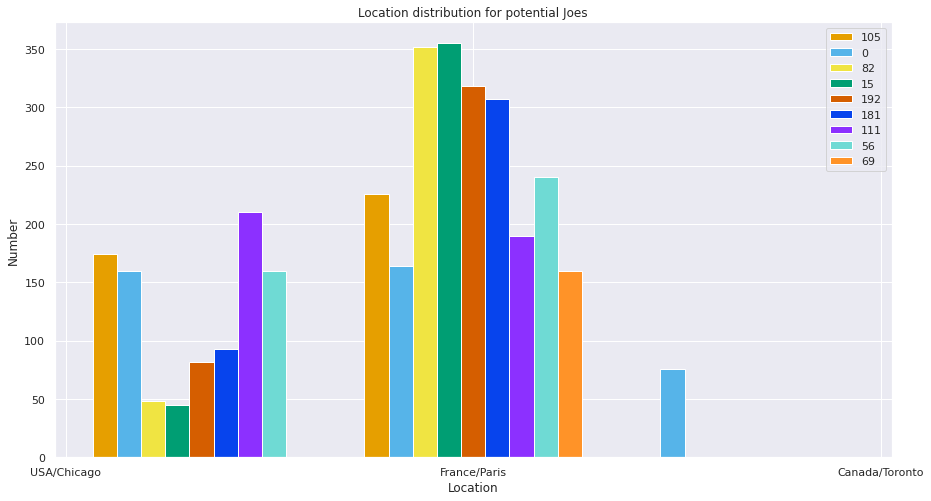

In [25]:
x1 = list(potential[potential['user_id'] == 105]['location'])
x2 = list(potential[potential['user_id'] == 0]['location'])
x3 = list(potential[potential['user_id'] == 82]['location'])
x4 = list(potential[potential['user_id'] == 15]['location'])
x5 = list(potential[potential['user_id'] == 192]['location'])
x6 = list(potential[potential['user_id'] == 181]['location'])
x7 = list(potential[potential['user_id'] == 111]['location'])
x8 = list(potential[potential['user_id'] == 56]['location'])
x9 = list(potential[potential['user_id'] == 69]['location'])

sns.set(rc = {'figure.figsize':(15,8)})
# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00', '#0744ED', '#8C30FF', '#6FDAD4', '#FF9328']
names = [105, 0, 82, 15, 192, 181, 111, 56, 69]
         
plt.hist([x1, x2, x3, x4, x5, x6, x7, x8, x9], bins = int(3),
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Location')
plt.ylabel('Number')
plt.title('Location distribution for potential Joes')


As we can see the distribution of location differs amogst the 9 users.

OS

In [26]:
os_dis = potential.groupby(['user_id'])['os'].value_counts()
os_dis

user_id  os        
0        Ubuntu        212
         Windows 10    188
15       Ubuntu        200
         Windows 10    200
56       Ubuntu        211
         Windows 10    189
69       Ubuntu         91
         Windows 10     69
82       Ubuntu        200
         Windows 10    200
105      Windows 10    212
         Ubuntu        188
111      Ubuntu        212
         Windows 10    188
181      Ubuntu        201
         Windows 10    199
192      Ubuntu        201
         Windows 10    199
Name: os, dtype: int64

As we can see for all user the distribution is around 50/50 for OS, thus this feature is not informative.

Browser

In [27]:
browser_dis = potential.groupby(['user_id'])['browser'].value_counts()
browser_dis

user_id  browser
0        Firefox    214
         Chrome     186
15       Firefox    202
         Chrome     198
56       Firefox    204
         Chrome     196
69       Firefox     86
         Chrome      74
82       Firefox    214
         Chrome     186
105      Firefox    204
         Chrome     196
111      Firefox    210
         Chrome     190
181      Chrome     208
         Firefox    192
192      Firefox    222
         Chrome     178
Name: browser, dtype: int64

Once again this feature is not informative as all of 9 users use Firefox and Chrome with distribution around 50/50.

Creating a dataframe

In [28]:
df = pd.DataFrame()
df['user_id'] = potential['user_id']
df['Joe'] = np.where(df['user_id'] == 0, 1, 0)
df['location'] = pd.factorize(potential["location"])[0]

# Activity analysis

Number of sites visited in a session

In [29]:
df['n_sites'] = potential['sites'].apply(len)

Let's see the distribution for each one of the users.

Text(0, 0.5, 'Density')

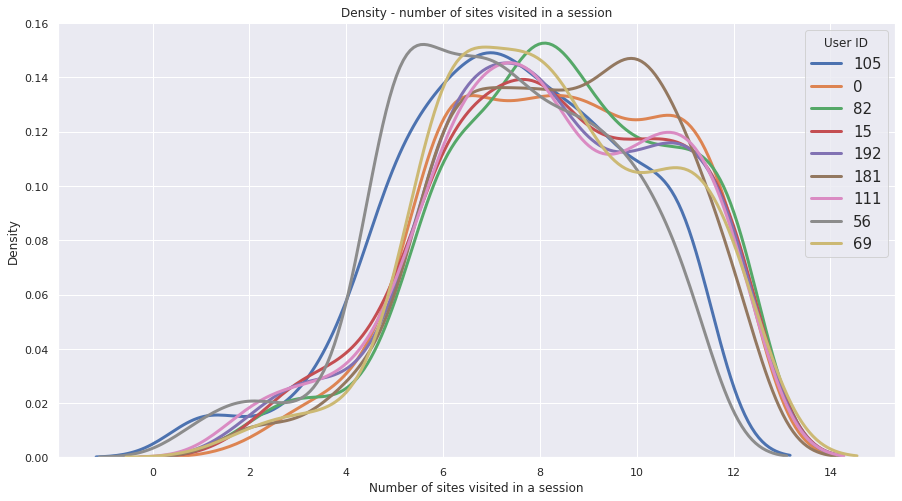

In [30]:
sns.set(rc = {'figure.figsize':(15,8)})
for id in pot_ids:
    subset = df[df['user_id'] == id]
    
    sns.distplot(subset['n_sites'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = id)
    
plt.legend(prop={'size': 15}, title = 'User ID', loc='upper right')
plt.title('Density - number of sites visited in a session')
plt.xlabel('Number of sites visited in a session')
plt.ylabel('Density')

Time spent on a session

Text(0, 0.5, 'Density')

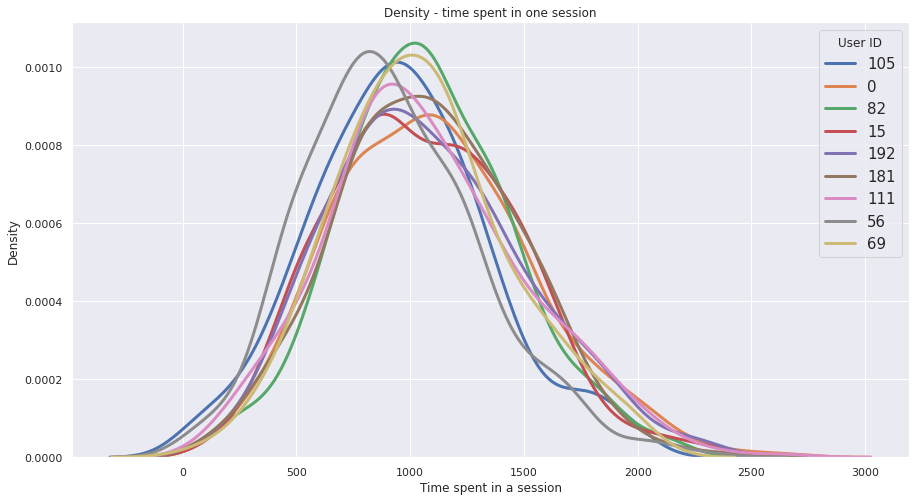

In [31]:
for id in pot_ids:
  subset = potential[potential['user_id'] == id]['sites']
  lens = []
  for row in subset:
    leng = 0
    for site in row:
      leng += site['length']
    lens.append(leng)
  sns.distplot(lens, hist = False, kde = True,
                 kde_kws = {'linewidth': 3}, label=id)
    
plt.legend(prop={'size': 15}, title = 'User ID', loc='upper right')
plt.title('Density - time spent in one session')
plt.xlabel('Time spent in a session')
plt.ylabel('Density')


As we can see the distrubution of length of session in time differs a little for different users.

In [32]:
def get_length(s):
    res = [0]
    for site in s:
      res[0] += site['length']  
    return pd.Series(res)

df['ses_len'] = potential["sites"].apply(lambda x: get_length(x))
df

user_id  Joe  location  n_sites  ses_len
0          105    0         0        6      481
77           0    1         1       10     1177
78          82    0         1       10     1039
90          15    0         1        9      913
166         82    0         0       11     1735
...        ...  ...       ...      ...      ...
79918        0    1         0        6      930
79977      192    0         1        8      687
79982        0    1         0        7     1187
79997        0    1         0        6      698
79998       56    0         1        5      696

[3360 rows x 5 columns]

What sites do users visit the most often?

In [33]:
for id in pot_ids:
  sites = {}
  subset = potential[potential['user_id'] == id]['sites']
  for row in subset:
    for site in row:
      if site['site'] not in sites:
        sites[site['site']] = 0
      sites[site['site']] += 1
  print(f"user {id}")
  sites = sorted(sites.items(), key=lambda x: x[1], reverse=True)
  print(sites)
  print('\n')

user 105
[('slack.com', 356), ('youtube.com', 353), ('toptal.com', 350), ('lenta.ru', 349), ('mail.google.com', 348), ('levillagedemusher.com', 3), ('misslipstick.fr', 3), ('mitchieville.com', 3), ('sinastorage.com', 2), ('lesseigneurs.fr', 2), ('eric-pidoux.com', 2), ('axf8.net', 2), ('centreimmo.com', 2), ('missiledine.com', 2), ('eol.org', 2), ('fteam.org', 2), ('qq937.com', 2), ('sagemath.org', 2), ('vaillant.fr', 2), ('monjavascript.net', 2), ('trelab.fi', 2), ('naruto-mx.com', 2), ('atlasformen.fr', 2), ('lettres-gratuites.com', 2), ('everyoneweb.fr', 2), ('gameduell.de', 2), ('nxtorm.es', 2), ('laboiteverte.fr', 2), ('newpharma.fr', 2), ('elasticad.net', 2), ('survival-le-jeu.com', 2), ('estudis.fr', 2), ('wal8.com', 2), ('pearltrees.com', 2), ('gametronik.com', 2), ('doi.org', 2), ('airsoft-project.com', 2), ('publiz.net', 2), ('mail-archive.com', 2), ('demooniak.com', 2), ('inside-r.org', 2), ('labo-microsoft.org', 2), ('esetstatic.com', 2), ('assoc-amazon.fr', 2), ('applovin.

From the analysis of the most frequently used sites we can see that every users uses up to 6 sites regularly :

slack.com, youtube,.com mail.google.com, toptal.com, vk.com and lenta.ru.

Let's see if the time users spend on particular websites differ.

In [34]:
SITES_NAMES = ['slack.com', 'youtube.com', 'mail.google.com', 'toptal.com', 'vk.com', 'lenta.ru']
columns = ['user_id','slack.com', 'youtube.com', 'mail.google.com', 'toptal.com', 'vk.com', 'lenta.ru']
user_sites = pd.DataFrame( columns=columns)

for id in pot_ids:
  subset = potential[potential['user_id'] == id]['sites']
  for row in subset:
    r = {'user_id' : id, 'slack.com' : 0, 'youtube.com' : 0, 'mail.google.com' : 0, 'toptal.com' : 0, 'vk.com' : 0, 'lenta.ru' : 0}
    for site in row:
      if site['site'] in SITES_NAMES:
        r[site['site']] = site['length']
    user_sites = user_sites.append(r, ignore_index = True)
user_sites



user_id slack.com youtube.com mail.google.com toptal.com vk.com lenta.ru
0        105        65          67              50        132      0       59
1        105         0         251               0          0      0        0
2        105         0         294               0          0      0        0
3        105       231         272              81        318      0       84
4        105       153         116             124         74      0       91
...      ...       ...         ...             ...        ...    ...      ...
3355      69        62         109             212         56    155       84
3356      69        89         156              55        190    193      166
3357      69       264          68              59         86    121      118
3358      69       137          43             139        321     44       43
3359      69         0           0               0         49     47        0

[3360 rows x 7 columns]

Check the distribution

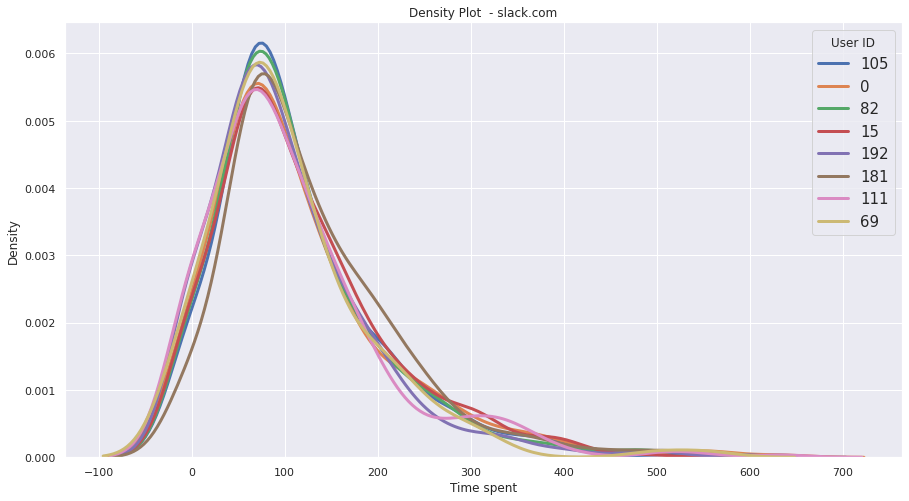

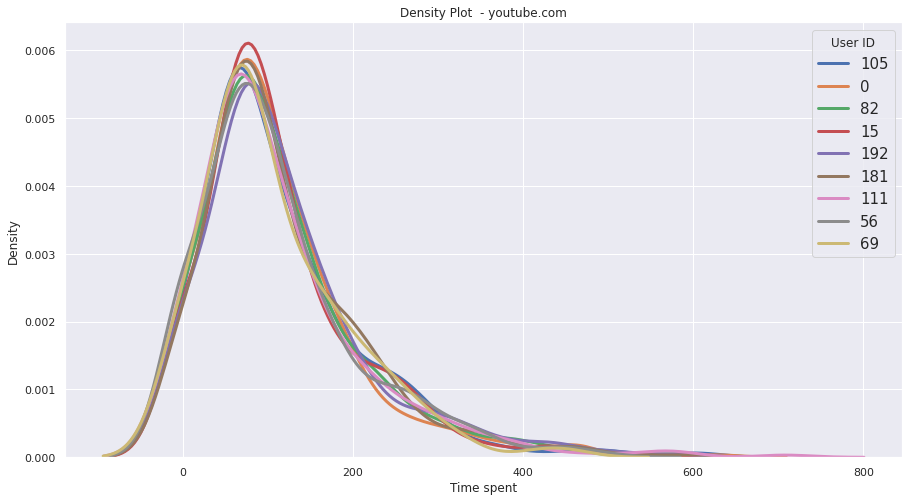

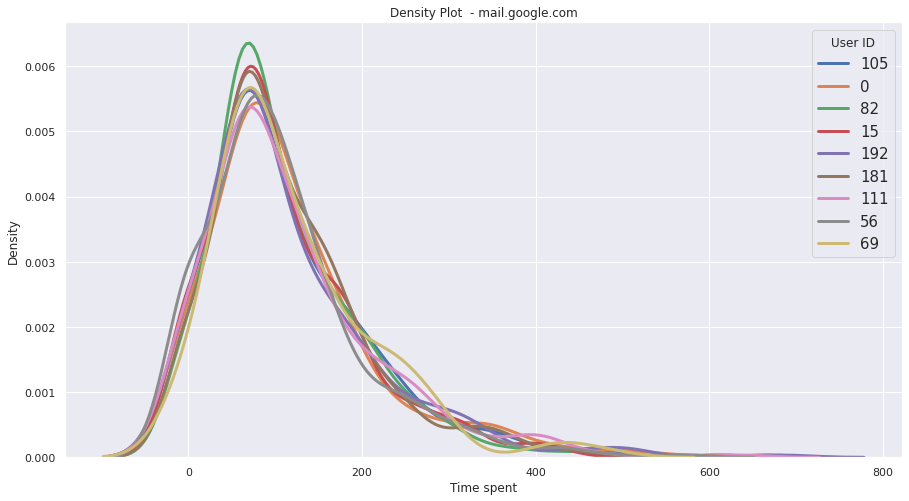

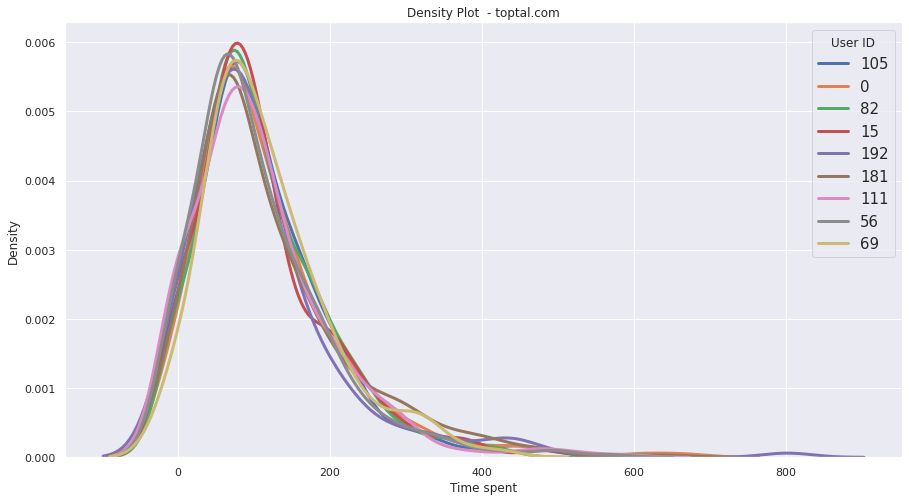

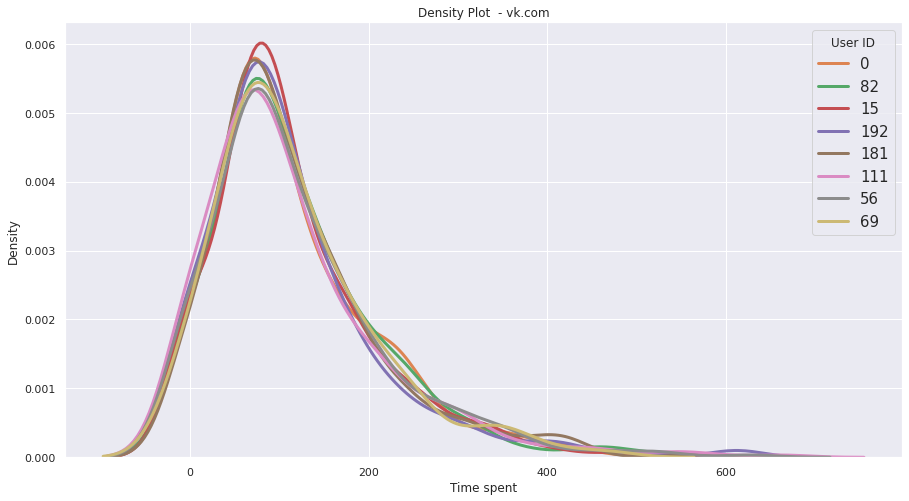

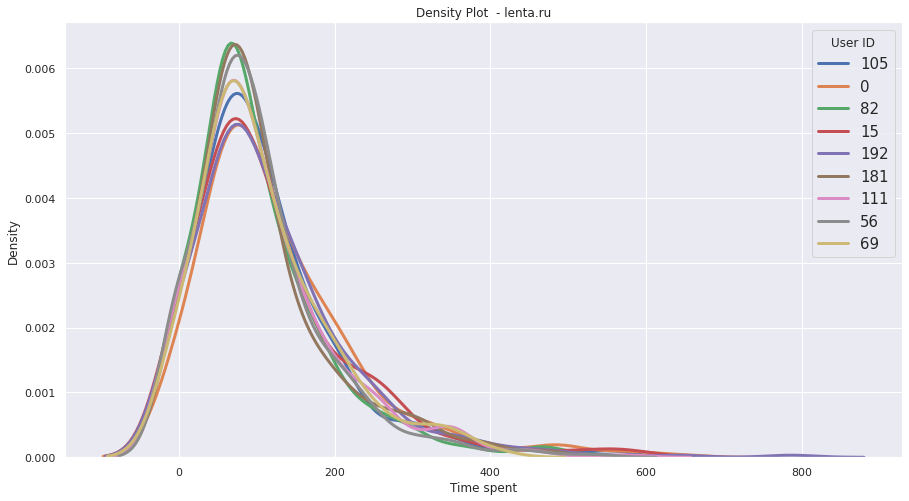

In [35]:
for site in SITES_NAMES:
  for id in pot_ids:
    subset = user_sites[user_sites['user_id'] == id]
    
    sns.distplot(subset[site], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = id)
    
  plt.legend(prop={'size': 15}, title = 'User ID', loc='upper right')
  plt.title(f'Density Plot  - {site}')
  plt.xlabel('Time spent')
  plt.ylabel('Density')
  plt.show()

As shown on the graphs above the density of time spent on particular site is almost the same for all the users.

Order of sites

In [36]:
SITES_NAMES = ['slack.com', 'youtube.com', 'mail.google.com', 'toptal.com', 'vk.com', 'lenta.ru']
columns = ['slack.com', 'youtube.com', 'mail.google.com', 'toptal.com', 'vk.com', 'lenta.ru', 'other', 'none']
order_sites = pd.DataFrame(0, index=np.arange(13), columns=columns)
order_sites
for id in pot_ids:
  subset = potential[potential['user_id'] == id]['sites']
  order_sites = pd.DataFrame(0, index=np.arange(13), columns=columns)
  for row in subset:
    for i, site in enumerate(row):
      if site['site'] in SITES_NAMES:
        order_sites.loc[i, site['site']] += 1
      else:
        order_sites.loc[i, 'other'] += 1
    for i in range(len(row), 13):
      order_sites.loc[i, 'none'] += 1
  print(f"user {id}")
  display(pd.DataFrame(order_sites))
  print('\n')

user 105


slack.com  youtube.com  mail.google.com  toptal.com  vk.com  lenta.ru  \
0          20           14              291          63       0        12   
1           7            5               43         248       0        62   
2          67           10                5          30       0       235   
3         234           67                7           5       0        34   
4           8          101                1           1       0         0   
5           9           52                1           0       0         2   
6           4           37                0           1       0         2   
7           4           30                0           1       0         1   
8           2           19                0           0       0         1   
9           1           11                0           0       0         0   
10          0            7                0           1       0         0   
11          0            0                0           0       0         0   
12          0            0                0           0       0         0   

    other  none  
0       0     0  
1      26     9  
2      40    13  
3      32    21  
4     249    40  
5     248    88  
6     213   143  
7     157   207  
8     117   261  
9      75   313  
10     39   353  
11      0   400  
12      0   400



user 0


slack.com  youtube.com  mail.google.com  toptal.com  vk.com  lenta.ru  \
0          15           15              302          13      42        13   
1          11           13               31          55     276        14   
2           2            5               11         254      28        63   
3          66            4                1          32       0       236   
4         102           22                1           0       1        14   
5          60           80                0           1       2        12   
6          52           58                0           1       2         4   
7          26           52                1           0       0         3   
8           9           35                1           1       1         2   
9           4           33                0           0       0         0   
10          3           23                0           1       0         0   
11          1            8                0           1       0         0   
12          0            0                0           0       0         0   

    other  none  
0       0     0  
1       0     0  
2      35     2  
3      51    10  
4     240    20  
5     204    41  
6     181   102  
7     166   152  
8     145   206  
9     103   260  
10     67   306  
11     28   362  
12      0   400



user 82


slack.com  youtube.com  mail.google.com  toptal.com  vk.com  lenta.ru  \
0          16           16              305          14      39        10   
1          12           10               33          57     270        18   
2           5            6                8         243      36        62   
3          71            2                3          31       1       229   
4         100           33                1           2       4        13   
5          70           70                4           2       2         7   
6          33           62                2           2       0         2   
7          20           51                0           1       0         1   
8          16           33                0           1       0         0   
9           9           29                1           1       0         2   
10          2           25                0           0       0         1   
11          0           12                0           0       1         0   
12          0            0                0           0       0         0   

    other  none  
0       0     0  
1       0     0  
2      35     5  
3      47    16  
4     225    22  
5     205    40  
6     207    92  
7     188   139  
8     141   209  
9      96   262  
10     65   307  
11     34   353  
12      0   400



user 15


slack.com  youtube.com  mail.google.com  toptal.com  vk.com  lenta.ru  \
0          18           16               13          42      14       297   
1           9           11               13         264      68        35   
2          11            6               74          33     232         6   
3           2           79              217           5      26         2   
4          29          117               11           0       3         2   
5          71           59                6           1       2         1   
6          64           24                7           0       3         0   
7          54           22                0           0       0         1   
8          37            9                3           0       0         1   
9          27            3                1           0       1         0   
10         21            1                1           0       0         0   
11          9            4                0           0       0         0   
12          0            0                0           0       0         0   

    other  none  
0       0     0  
1       0     0  
2      34     4  
3      52    17  
4     208    30  
5     208    52  
6     199   103  
7     166   157  
8     133   217  
9     106   262  
10     68   309  
11     30   357  
12      0   400



user 192


slack.com  youtube.com  mail.google.com  toptal.com  vk.com  lenta.ru  \
0          13           20               14          54      18       281   
1          11           18               21         246      63        41   
2           9            9               63          35     233        10   
3          70            4              223           2      23         4   
4         107           23               13           2       5         2   
5          55           68                8           4       2         3   
6          36           65                3           2       0         0   
7          18           49                1           0       0         4   
8          14           34                1           0       0         0   
9           6           28                1           1       0         1   
10          2           22                0           0       1         0   
11          0           10                0           0       0         0   
12          0            0                0           0       0         0   

    other  none  
0       0     0  
1       0     0  
2      35     6  
3      55    19  
4     219    29  
5     213    47  
6     191   103  
7     166   162  
8     129   222  
9      98   265  
10     66   309  
11     31   359  
12      0   400



user 181


slack.com  youtube.com  mail.google.com  toptal.com  vk.com  lenta.ru  \
0          13           17               11          54       9       296   
1          17            7               11         266      67        32   
2           7            6               65          27     254         9   
3           5           84              233           4      20         2   
4          30           97               14           1       2         1   
5          74           71               10           0       3         1   
6          70           42                5           1       1         3   
7          60           18                3           0       1         2   
8          51            6                2           0       1         2   
9          26            4                0           1       0         1   
10         14            3                1           1       0         1   
11          4            0                0           0       0         0   
12          0            0                0           0       0         0   

    other  none  
0       0     0  
1       0     0  
2      26     6  
3      42    10  
4     234    21  
5     203    38  
6     183    95  
7     167   149  
8     134   204  
9     112   256  
10     59   321  
11     26   370  
12      0   400



user 111


slack.com  youtube.com  mail.google.com  toptal.com  vk.com  lenta.ru  \
0          19           19              298          11      36        17   
1          10           18               32          60     264        16   
2           6            7                8         241      31        49   
3          59            1                3          18       2       240   
4         123           30                3           3       1         9   
5          54           81                0           0       1         3   
6          26           52                1           0       2         4   
7          20           49                0           0       0         3   
8          13           28                0           2       4         2   
9           4           34                1           0       0         3   
10          3           22                0           0       0         0   
11          0            7                0           0       1         0   
12          0            0                0           0       0         0   

    other  none  
0       0     0  
1       0     0  
2      49     9  
3      57    20  
4     200    31  
5     209    52  
6     212   103  
7     165   163  
8     127   224  
9      95   263  
10     66   309  
11     30   362  
12      0   400



user 56


slack.com  youtube.com  mail.google.com  toptal.com  vk.com  lenta.ru  \
0           0           16               10          62      21       291   
1           0            8               10         236      64        40   
2           0            4               61          40     226         3   
3           0           69              224           4      33         4   
4           0          105                9           1       1         4   
5           0           62                6           1       1         2   
6           0           29                5           0       0         0   
7           0           23                3           0       0         0   
8           0           11                3           0       1         0   
9           0            7                1           0       0         0   
10          0            6                1           0       0         0   
11          0            0                0           0       0         0   
12          0            0                0           0       0         0   

    other  none  
0       0     0  
1      36     6  
2      50    16  
3      44    22  
4     247    33  
5     223   105  
6     205   161  
7     151   223  
8     111   274  
9      67   325  
10     24   369  
11      0   400  
12      0   400



user 69


slack.com  youtube.com  mail.google.com  toptal.com  vk.com  lenta.ru  \
0           3            6              124           4      20         3   
1           4            2               19          25     106         4   
2           2            2                2         106      13        21   
3          26            1                1          11       0        99   
4          49           13                0           0       1         8   
5          22           32                0           1       0         4   
6          20           27                0           0       0         1   
7           6           20                1           0       0         2   
8           5           15                0           0       1         0   
9           1            9                0           0       2         0   
10          0            9                0           0       0         0   
11          0            3                0           0       0         0   
12          0            0                0           0       0         0   

    other  none  
0       0     0  
1       0     0  
2      12     2  
3      17     5  
4      82     7  
5      89    12  
6      68    44  
7      67    64  
8      47    92  
9      38   110  
10     27   124  
11     13   144  
12      0   160

In [37]:
orders = ["order"+str(i) for i in range(12)]
site_codes = ['none'] + SITES_NAMES + ['other']
def get_order(s):
    res = [0]*12
    for i, site in enumerate(s):
        if site["site"] in SITES_NAMES:
            res[i] = site_codes.index(site["site"])
        else:
            res[i] = len(site_codes)-1
    return pd.Series(res, index=orders)

df[orders] = potential["sites"].apply(lambda x: get_order(x))

# Datetime

In [38]:
potential[['day', 'month', 'year', 'dayofweek']] = potential["date"].apply(lambda x: pd.Series([x.day, x.month, x.year, x.dayofweek]))
potential['hour'] = potential['time'].apply(lambda x: pd.to_datetime(x).hour + pd.to_datetime(x).minute/60)
potential

browser          os locale  user_id gender      location  \
0      Firefox      Ubuntu  ru_RU      105      m   USA/Chicago   
77     Firefox  Windows 10  ru_RU        0      m  France/Paris   
78      Chrome      Ubuntu  ru_RU       82      m  France/Paris   
90      Chrome      Ubuntu  ru_RU       15      m  France/Paris   
166     Chrome      Ubuntu  ru_RU       82      m   USA/Chicago   
...        ...         ...    ...      ...    ...           ...   
79918  Firefox      Ubuntu  ru_RU        0      m   USA/Chicago   
79977   Chrome  Windows 10  ru_RU      192      m  France/Paris   
79982   Chrome  Windows 10  ru_RU        0      m   USA/Chicago   
79997  Firefox      Ubuntu  ru_RU        0      m   USA/Chicago   
79998  Firefox  Windows 10  ru_RU       56      m  France/Paris   

                                                   sites      time       date  \
0      [{'site': 'mail.google.com', 'length': 50}, {'...  09:03:00 2017-01-08   
77     [{'site': 'mail.google.com', 'length': 86}, {'...  10:13:00 2016-04-30   
78     [{'site': 'vk.com', 'length': 161}, {'site': '...  14:25:00 2016-06-18   
90     [{'site': 'lenta.ru', 'length': 279}, {'site':...  19:14:00 2017-06-23   
166    [{'site': 'mail.google.com', 'length': 59}, {'...  21:22:00 2017-06-16   
...                                                  ...       ...        ...   
79918  [{'site': 'mail.google.com', 'length': 80}, {'...  17:46:00 2016-12-12   
79977  [{'site': 'vk.com', 'length': 51}, {'site': 'y...  00:28:00 2016-08-13   
79982  [{'site': 'vk.com', 'length': 109}, {'site': '...  02:35:00 2017-05-02   
79997  [{'site': 'vk.com', 'length': 44}, {'site': 's...  17:55:00 2017-03-13   
79998  [{'site': 'lenta.ru', 'length': 82}, {'site': ...  14:17:00 2016-12-06   

       day  month  year  dayofweek       hour  
0        8      1  2017          6   9.050000  
77      30      4  2016          5  10.216667  
78      18      6  2016          5  14.416667  
90      23      6  2017          4  19.233333  
166     16      6  2017          4  21.366667  
...    ...    ...   ...        ...        ...  
79918   12     12  2016          0  17.766667  
79977   13      8  2016          5   0.466667  
79982    2      5  2017          1   2.583333  
79997   13      3  2017          0  17.916667  
79998    6     12  2016          1  14.283333  

[3360 rows x 14 columns]

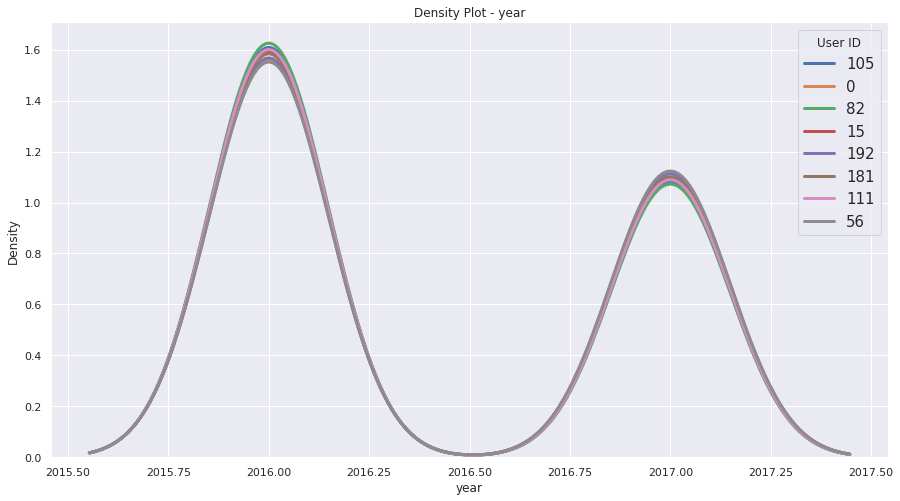

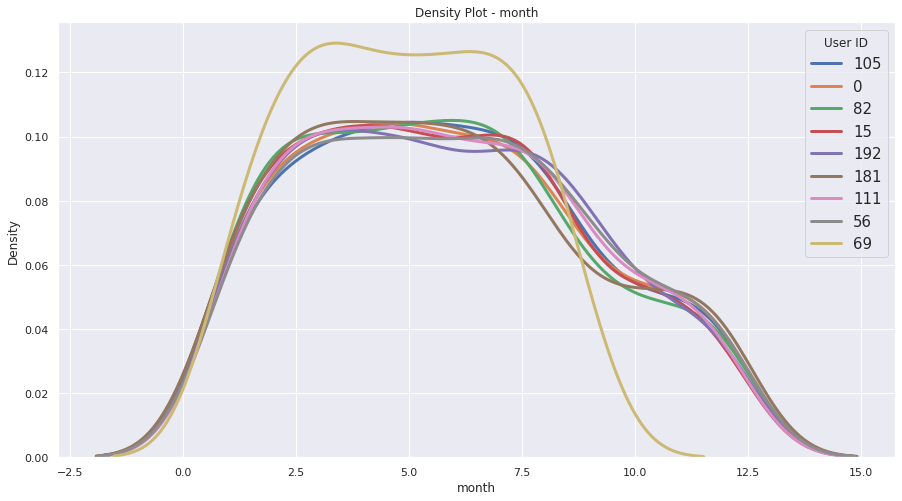

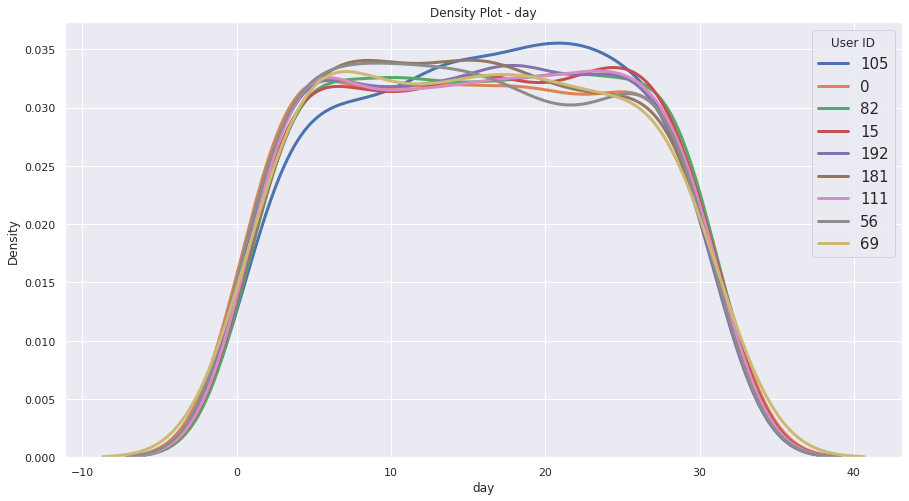

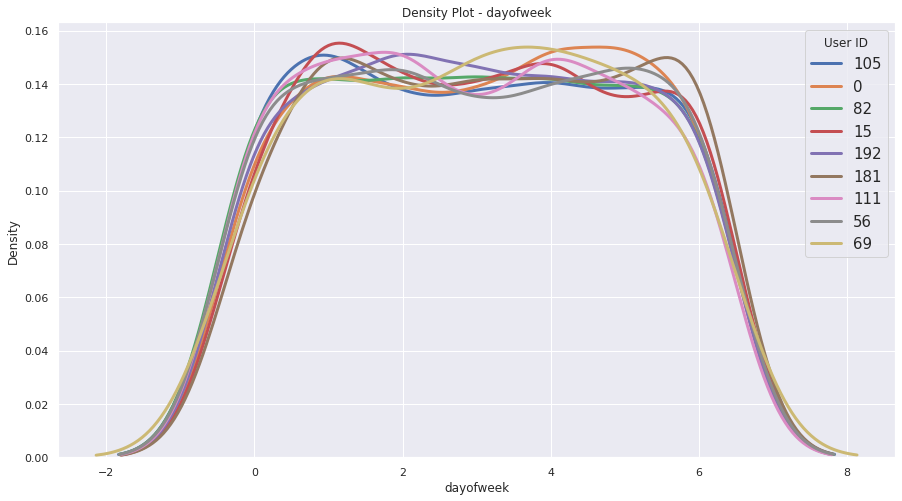

In [39]:
sns.set(rc = {'figure.figsize':(15,8)})
date = ['year', 'month', 'day', 'dayofweek']
for date in date:
  for id in pot_ids:
      subset = potential[potential['user_id'] == id][date]
      
      sns.distplot(subset, hist = False, kde = True,
                  kde_kws = {'linewidth': 3},
                  label = id)
      
  plt.legend(prop={'size': 15}, title = 'User ID', loc='upper right')
  plt.title(f'Density Plot - {date}')
  plt.xlabel(f'{date}')
  plt.ylabel('Density')
  plt.show()

The distributions for date parts don't differ much - they are not informative.

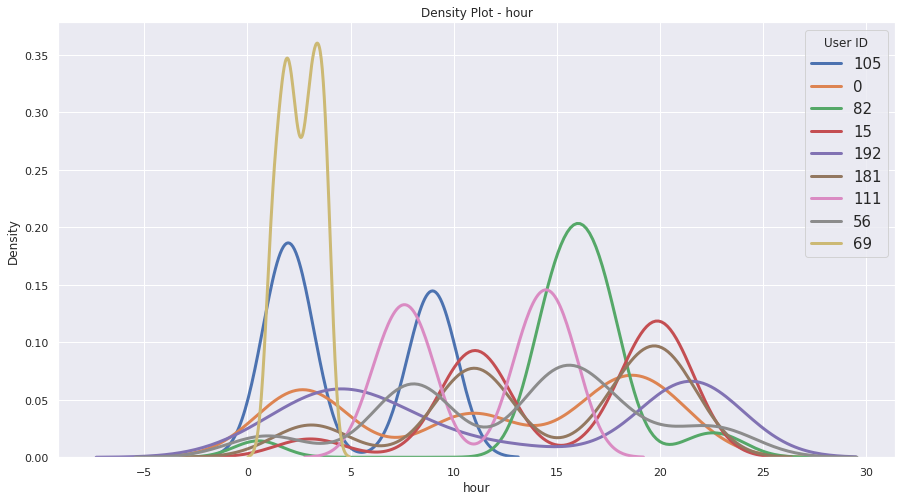

In [40]:
for id in pot_ids:
      subset = potential[potential['user_id'] == id]['hour']
      
      sns.distplot(subset, hist = False, kde = True,
                  kde_kws = {'linewidth': 3},
                  label = id)
      
plt.legend(prop={'size': 15}, title = 'User ID', loc='upper right')
plt.title('Density Plot - hour')
plt.xlabel('hour')
plt.ylabel('Density')
plt.show()

The distributions of hours differ for different potential joes so this feature is informative.

In [41]:
df['month'] = potential['month']
df['day'] = potential['day']
df['dayofweek'] = potential['dayofweek']
df['hour'] = potential['hour']
df

user_id  Joe  location  n_sites  ses_len  order0  order1  order2  \
0          105    0         0        6      481       3       4       1   
77           0    1         1       10     1177       3       5       6   
78          82    0         1       10     1039       5       3       4   
90          15    0         1        9      913       6       4       3   
166         82    0         0       11     1735       3       5       6   
...        ...  ...       ...      ...      ...     ...     ...     ...   
79918        0    1         0        6      930       3       5       4   
79977      192    0         1        8      687       5       2       1   
79982        0    1         0        7     1187       5       3       4   
79997        0    1         0        6      698       5       1       3   
79998       56    0         1        5      696       6       4       5   

       order3  order4  ...  order6  order7  order8  order9  order10  order11  \
0           6       2  ...       0       0       0       0        0        0   
77          1       2  ...       7       7       7       7        0        0   
78          6       7  ...       7       7       7       2        0        0   
90          5       2  ...       1       7       7       0        0        0   
166         4       7  ...       7       7       2       7        7        0   
...       ...     ...  ...     ...     ...     ...     ...      ...      ...   
79918       1       6  ...       0       0       0       0        0        0   
79977       7       7  ...       7       7       0       0        0        0   
79982       6       1  ...       2       0       0       0        0        0   
79997       7       7  ...       0       0       0       0        0        0   
79998       3       2  ...       0       0       0       0        0        0   

       month  day  dayofweek       hour  
0          1    8          6   9.050000  
77         4   30          5  10.216667  
78         6   18          5  14.416667  
90         6   23          4  19.233333  
166        6   16          4  21.366667  
...      ...  ...        ...        ...  
79918     12   12          0  17.766667  
79977      8   13          5   0.466667  
79982      5    2          1   2.583333  
79997      3   13          0  17.916667  
79998     12    6          1  14.283333  

[3360 rows x 21 columns]

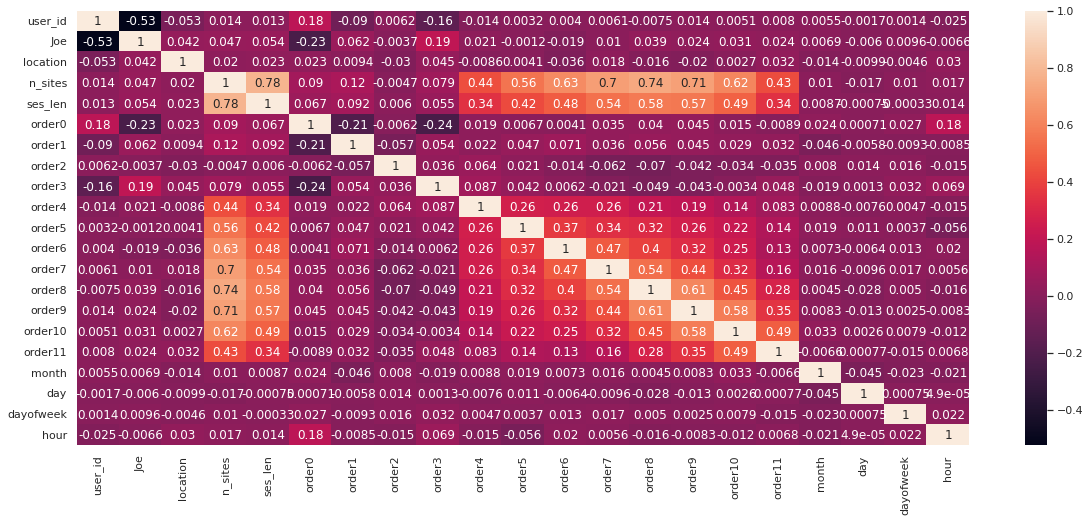

In [96]:
sns.set(rc = {'figure.figsize':(20,8)})
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there is a correlation between being a Joe and 1st and 4th sites visited. 

What's interesting it seems that the correlation between being a Joe and location and hour isn't as strong as I might have thought.

# Model Training

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import xgboost
from sklearn import svm, tree

In [43]:
df.columns
df

user_id  Joe  location  n_sites  ses_len  order0  order1  order2  \
0          105    0         0        6      481       3       4       1   
77           0    1         1       10     1177       3       5       6   
78          82    0         1       10     1039       5       3       4   
90          15    0         1        9      913       6       4       3   
166         82    0         0       11     1735       3       5       6   
...        ...  ...       ...      ...      ...     ...     ...     ...   
79918        0    1         0        6      930       3       5       4   
79977      192    0         1        8      687       5       2       1   
79982        0    1         0        7     1187       5       3       4   
79997        0    1         0        6      698       5       1       3   
79998       56    0         1        5      696       6       4       5   

       order3  order4  ...  order6  order7  order8  order9  order10  order11  \
0           6       2  ...       0       0       0       0        0        0   
77          1       2  ...       7       7       7       7        0        0   
78          6       7  ...       7       7       7       2        0        0   
90          5       2  ...       1       7       7       0        0        0   
166         4       7  ...       7       7       2       7        7        0   
...       ...     ...  ...     ...     ...     ...     ...      ...      ...   
79918       1       6  ...       0       0       0       0        0        0   
79977       7       7  ...       7       7       0       0        0        0   
79982       6       1  ...       2       0       0       0        0        0   
79997       7       7  ...       0       0       0       0        0        0   
79998       3       2  ...       0       0       0       0        0        0   

       month  day  dayofweek       hour  
0          1    8          6   9.050000  
77         4   30          5  10.216667  
78         6   18          5  14.416667  
90         6   23          4  19.233333  
166        6   16          4  21.366667  
...      ...  ...        ...        ...  
79918     12   12          0  17.766667  
79977      8   13          5   0.466667  
79982      5    2          1   2.583333  
79997      3   13          0  17.916667  
79998     12    6          1  14.283333  

[3360 rows x 21 columns]

In [120]:
loc = ['location']
session = ['ses_len', 'n_sites']
periods = ["dayofweek", "day", "month", "hour"]
orders = ["order"+ str(i) for i in range(12)]
X_train, X_test, y_train, y_test = train_test_split(df[["hour"] + ["location"] + [orders[0]] + [orders[1]] + [orders[3]]], df["Joe"], test_size=0.15)

Choosing a classification algorithm

In [121]:
from sklearn import neighbors
classifiers = []
model1 = xgboost.XGBClassifier()
classifiers.append(model1)
model2 = neighbors.KNeighborsClassifier()
classifiers.append(model2)
model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)

In [122]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test)
    bacc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy of %s is %s"%(clf, bacc))
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy of %s is %s"%(clf, acc))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of %s is %s"%(clf, cm))
    print("\n")


Balanced accuracy of XGBClassifier() is 0.9407670454545455
Accuracy of XGBClassifier() is 0.9781746031746031
Confusion Matrix of XGBClassifier() is [[436   4]
 [  7  57]]


Balanced accuracy of KNeighborsClassifier() is 0.9116477272727272
Accuracy of KNeighborsClassifier() is 0.9623015873015873
Confusion Matrix of KNeighborsClassifier() is [[431   9]
 [ 10  54]]


Balanced accuracy of DecisionTreeClassifier() is 0.9350852272727272
Accuracy of DecisionTreeClassifier() is 0.9682539682539683
Confusion Matrix of DecisionTreeClassifier() is [[431   9]
 [  7  57]]


Balanced accuracy of RandomForestClassifier() is 0.9419034090909091
Accuracy of RandomForestClassifier() is 0.9801587301587301
Confusion Matrix of RandomForestClassifier() is [[437   3]
 [  7  57]]




We get the best scores for Decission tree classifier and "hour", "location" and 3 sites (1st, 2nd and 4th) visited in a session.

Random Forest

In [123]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion':['gini', 'entropy'],
    'max_depth': [10, 20, 50, 100],
    'min_samples_split': [2, 4, 6, 10],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(model4, param_grid = param_grid, cv = 5, verbose = 5, n_jobs = -1)
grid.fit(X_train, y_train)

best_estimator = grid.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [124]:
best_pred_y = best_estimator.predict(X_test)
print("Balanced accuracy: {}%".format(balanced_accuracy_score(y_test, best_pred_y)*100))
print("Accuracy: {}%".format(accuracy_score(y_test, best_pred_y)*100))
print("Confusion Matrix:")
print("{}".format(confusion_matrix(y_test, best_pred_y)))

Balanced accuracy: 94.9715909090909%
Accuracy: 98.21428571428571%
Confusion Matrix:
[[437   3]
 [  6  58]]
